In [1]:
import pandas as pd
import numpy as np

In [2]:
import utils
from DataLoader import DataLoader as DL
from DataLoader18 import DataLoader as DL18

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [5]:
import statsmodels.tsa.api as sta
import statsmodels.tsa.stattools as stattools
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import statsmodels.stats.stattools as stools

import scipy.stats as stats

In [22]:
loc = 'C:/Users/Biao Feng/source/Anaconda3/practicum/'
d = DL(loc)

C:\Users\Biao Feng\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3267: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
from DataLoader18 import DataLoader as DL18
loc = 'C:/Users/Biao Feng/source/Anaconda3/practicum/'
d18 = DL18(loc)

C:\Users\Biao Feng\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3267: DtypeWarning: Columns (9,49) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Biao Feng\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [6]:
def norm_rank(kk):
    ## for every row, rank from small to big, then minus 0.5, 
    ## then divide number of data in row
    ## ppf: inverse function of cdf
    ## - 0.5 make sure no 1 or 0 in the ppf
    tmp = stats.norm.ppf((kk.rank(1)-.5).div(kk.count(1), 0))
    ## set index and columns
    kk = pd.DataFrame(tmp, index=kk.index, columns=kk.columns)
    ## normalization
    kk = kk.div(kk.std(1), 0)
    return kk

def chi_rank(kk):
    ## for every row, rank from small to big, then minus 0.5, 
    ## then divide number of data in row
    ## ppf: inverse function of cdf
    ## - 0.5 make sure no 1 or 0 in the ppf
    tmp = stats.chi2.ppf((kk.rank(1)-.5).div(kk.count(1), 0), 1)
    ## set index and columns
    kk = pd.DataFrame(tmp, index=kk.index, columns=kk.columns)
    ## normalization
    kk = kk.sub(kk.mean(1),0).div(kk.std(1), 0)
    return kk

def get_cross_section(df,col_name):
    tt = df.stack().reset_index().rename(columns={0: col_name})
    return tt

In [7]:
import tqdm

In [8]:
all_vars = {}
for i in tqdm.tqdm(range(0,len(d.cols_q))):
    all_vars[d.cols_q[i]] = d.get_time_series(d.merged_table, d.cols_q[i], icol='datadate')

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [01:14<00:00,  1.24s/it]


In [65]:
merge_table = pd.concat([d.merged_table, d18.merged_table]).sort_values(['gvkey','datadate']).drop_duplicates(['gvkey','datadate'], keep = 'first')

In [67]:
merge_table = merge_table.sort_values(['gvkey','datadate'])


(467933, 78)

In [3]:
import pandas as pd
m = pd.read_csv('merged_table_full')
print(m.shape)

(467933, 79)


In [68]:
merge_table1 = merge_table.drop_duplicates(['gvkey','datadate'], keep = 'first')
merge_table1.shape

(463409, 78)

In [9]:
mcap = d.get_time_series(d.merged_table, 'mcap')
ret = d.get_time_series(d.merged_table, 'RET')

## if data's mcap is bigger than breakpoint
d.merged_table.loc[:, 'in_universe']=[np.nan if pd.isnull(m) or pd.isnull(b) or m < b else 1 
                                      for m,b in zip(d.merged_table.mcap.values, d.merged_table.breakpt.values)]

In [70]:
merge_table.to_csv('merged_table_full.csv')

In [10]:
# use data only after 1977
st = '1977'

#make example by industry 11
industry = 'i3'

#get industry universe
in_universe = d.get_time_series(d.merged_table[d.merged_table[industry]==1], 'in_universe')
in_univ = in_universe[st:].fillna(method='ffill', limit=3)

In [11]:
cols = in_univ.loc[:, in_univ.count()>0].columns
len(cols), len(in_univ.columns)

(2456, 2631)

In [20]:
# book value growth
equity = (all_vars['atq'].loc[st:,cols] - all_vars['ltq'].loc[st:,cols])

In [13]:
new_metric = np.log(1+equity.diff()/all_vars['atq'].shift(1))
new_metric_mean = new_metric.rolling(20).mean()
new_metric_std = new_metric.rolling(20).std()

C:\Users\Biao Feng\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


In [14]:
equity_chg = np.log(equity).diff().rolling(20).mean()
equity_chg_std = np.log(equity).diff().rolling(20).std()

C:\Users\Biao Feng\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.
C:\Users\Biao Feng\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


In [15]:
y_equity_chg = norm_rank(new_metric_mean).stack().reset_index().rename(columns={0: 'book_value growth'})

C:\Users\Biao Feng\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1904: RuntimeWarning: invalid value encountered in greater
  cond1 = (0 < q) & (q < 1)
C:\Users\Biao Feng\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1904: RuntimeWarning: invalid value encountered in less
  cond1 = (0 < q) & (q < 1)


In [16]:
# book to market
b2m = np.log(equity / mcap * 1000)
y_b2m = norm_rank(b2m).stack().reset_index().rename(columns={0: 'book to market'})

C:\Users\Biao Feng\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


In [17]:
for c in tqdm.tqdm(d.cols_q):
    # 5 year mean
    if c != 'atq': 
        tt = (all_vars[c] / all_vars['atq']).loc[st:,cols]
    else:    
        tt = np.log(all_vars[c].loc[st:,cols]).diff()
    
    all_vars['x_mean_' + c] = norm_rank(tt.rolling(20, min_periods=16).mean()).stack().reset_index().rename(columns={0: c+'_mean'})
    
    # 5 year std
    all_vars['x_std_' + c] = tt.rolling(20, min_periods=16).std().stack().reset_index().rename(columns={0: c+'_std'})

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:25<00:00,  2.40it/s]


In [18]:
th = 0.5
regressors = []
for c in tqdm.tqdm(d.cols_q):
    tt = all_vars['x_mean_' + c].pivot(index='datadate', columns='gvkey', values=all_vars['x_mean_' + c].columns[-1])
    if ((tt * in_univ).count(1)/in_univ.count(1))['1982':].quantile(0.5) > th:
        regressors.append('x_mean_' + c)

for c in tqdm.tqdm(d.cols_q):
    tt = all_vars['x_std_' + c].pivot(index='datadate', columns='gvkey', values=all_vars['x_std_' + c].columns[-1])
    if ((tt * in_univ).count(1)/in_univ.count(1))['1982':].quantile(0.5) > th:
        regressors.append('x_std_' + c)

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 13.49it/s]


In [19]:
reg_panel = pd.merge(y_equity_chg ,y_b2m,on=['gvkey', 'datadate'], how ='inner')
for i in regressors:
    if 'mean' in i:
        all_vars[i] = all_vars[i].fillna(0)
    elif 'std' in i:
        all_vars[i]= all_vars[i].fillna(all_vars[i].mean())
    reg_panel = pd.merge(reg_panel, all_vars[i], on=['gvkey', 'datadate'], how ='inner')

In [23]:
reg_panel.columns.count

AttributeError: 'Index' object has no attribute 'count'

In [ ]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.06)

In [21]:
from sklearn.model_selection import train_test_split
X = reg_panel.iloc[:, 4:].values
y = reg_panel['book_value growth'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [11]:
loc = 'C:/Users/Biao Feng/source/Anaconda3/practicum/'
#get test set
from DataLoader18 import DataLoader as DL18
d18 = DL18(loc)
all_vars18 = {}
for i in tqdm.tqdm(range(0,len(d18.cols_q))):
    all_vars18[d18.cols_q[i]] = d18.get_time_series(d18.merged_table, d18.cols_q[i], icol='datadate')
mcap = d18.get_time_series(d18.merged_table, 'mcap')
ret = d18.get_time_series(d18.merged_table, 'RET')
## if data's mcap is bigger than breakpoint
d18.merged_table.loc[:, 'in_universe']=[np.nan if pd.isnull(m) or pd.isnull(b) or m < b else 1 
                                      for m,b in zip(d18.merged_table.mcap.values, d18.merged_table.breakpt.values)]
# use data only after 2001
st = '2001'
#make example by industry 11
industry = 'i1'
in_universe18 = d18.get_time_series(d18.merged_table[d18.merged_table[industry]==1], 'in_universe')
in_univ18 = in_universe18[st:].fillna(method='ffill', limit=3)
cols18 = in_univ18.columns
# book value growth
equity18 = (all_vars18['atq'].loc[st:,cols18] - all_vars18['ltq'].loc[st:,cols18])
new_metric18 = np.log(1+equity18.diff()/all_vars18['atq'].shift(1))
new_metric_mean18 = new_metric18.rolling(20).mean()
new_metric_std18 = new_metric18.rolling(20).std()
y_equity_chg18 = norm_rank(new_metric_mean18).stack().reset_index().rename(columns={0: 'book_value growth'})
# book to market
b2m18 = np.log(equity18 / mcap * 1000)
y_b2m18 = norm_rank(b2m18).stack().reset_index().rename(columns={0: 'book to market'})
reg_panel = pd.merge(y_equity_chg18 ,y_b2m18,on=['gvkey', 'datadate'], how ='inner')

C:\Users\Biao Feng\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3267: DtypeWarning: Columns (9,49) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Biao Feng\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:33<00:00,  1.79it/s]


NameError: in_universe does not exist

In [15]:
all_vars18 = {}
for i in tqdm.tqdm(range(0,len(d18.cols_q))):
    all_vars18[d18.cols_q[i]] = d18.get_time_series(d18.merged_table, d18.cols_q[i], icol='datadate')
mcap = d18.get_time_series(d18.merged_table, 'mcap')
ret = d18.get_time_series(d18.merged_table, 'RET')
## if data's mcap is bigger than breakpoint
d18.merged_table.loc[:, 'in_universe']=[np.nan if pd.isnull(m) or pd.isnull(b) or m < b else 1 
                                      for m,b in zip(d18.merged_table.mcap.values, d18.merged_table.breakpt.values)]
# use data only after 2001
st = '2001'
#make example by industry 11
industry = 'i1'
in_universe18 = d18.get_time_series(d18.merged_table[d18.merged_table[industry]==1], 'in_universe')
in_univ18 = in_universe18[st:].fillna(method='ffill', limit=3)
cols18 = in_univ18.columns
# book value growth
equity18 = (all_vars18['atq'].loc[st:,cols18] - all_vars18['ltq'].loc[st:,cols18])
new_metric18 = np.log(1+equity18.diff()/all_vars18['atq'].shift(1))
new_metric_mean18 = new_metric18.rolling(20).mean()
new_metric_std18 = new_metric18.rolling(20).std()
y_equity_chg18 = norm_rank(new_metric_mean18).stack().reset_index().rename(columns={0: 'book_value growth'})
# book to market
b2m18 = np.log(equity18 / mcap * 1000)
y_b2m18 = norm_rank(b2m18).stack().reset_index().rename(columns={0: 'book to market'})
reg_panel = pd.merge(y_equity_chg18 ,y_b2m18,on=['gvkey', 'datadate'], how ='inner')
y_test = y_b2m18

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:33<00:00,  1.79it/s]
C:\Users\Biao Feng\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1904: RuntimeWarning: invalid value encountered in greater
  cond1 = (0 < q) & (q < 1)
C:\Users\Biao Feng\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1904: RuntimeWarning: invalid value encountered in less
  cond1 = (0 < q) & (q < 1)
C:\Users\Biao Feng\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log


In [16]:
print(y_test)

       datadate   gvkey  book to market
0    2001-09-30    1380        0.664287
1    2001-09-30    1661       -0.056301
2    2001-09-30    1678        0.609274
3    2001-09-30    1860        0.146826
4    2001-09-30    1976       -1.580473
5    2001-09-30    2270        0.261776
6    2001-09-30    2437        0.238560
7    2001-09-30    3107        2.227302
8    2001-09-30    3153       -1.224997
9    2001-09-30    4367       -0.285133
10   2001-09-30    4844        0.721364
11   2001-09-30    5187       -0.238560
12   2001-09-30    5439       -0.692547
13   2001-09-30    5560        0.215470
14   2001-09-30    5581        0.529986
15   2001-09-30    5686       -2.019497
16   2001-09-30    6403       -0.556027
17   2001-09-30    6788        1.135388
18   2001-09-30    6936        1.441456
19   2001-09-30    7017        1.053989
20   2001-09-30    7422        1.663037
21   2001-09-30    7466       -1.507366
22   2001-09-30    7620       -0.843235
23   2001-09-30    7881       -1.273684


In [10]:
a =pd.read_csv('{loc}link table 2001-2018_csv.zip'.format(loc=loc))
print(a.columns)

Index(['gvkey', 'conm', 'tic', 'cusip', 'cik', 'sic', 'naics', 'LINKPRIM',
       'LIID', 'LINKTYPE', 'LPERMNO', 'LPERMCO', 'LINKDT', 'LINKENDDT', 'EIN',
       'COSTAT', 'DLRSN', 'PRIUSA', 'PRICAN', 'PRIROW', 'IDBFLAG', 'FIC',
       'LOC', 'INCORP', 'STATE', 'COUNTY', 'CITY', 'CONML', 'WEBURL', 'PHONE',
       'FAX', 'ADD1', 'ADD2', 'ADD3', 'ADD4', 'ADDZIP', 'BUSDESC', 'ipodate',
       'dldte', 'STKO', 'FYRC', 'GSECTOR', 'GGROUP', 'GIND', 'GSUBIND',
       'SPCINDCD', 'SPCSECCD'],
      dtype='object')


In [56]:
lasso.fit(X_train, y_train)

# Compute and print the coefficients
lasso_coef = lasso.coef_
print(lasso_coef)

[-0.00000000e+00  3.91139216e-02  0.00000000e+00  6.61830966e-01
  0.00000000e+00  3.09796579e-02  1.01927639e-03  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  4.11148044e-02  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -3.13322605e-02  2.62819740e-01 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  2.36898169e-06 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000

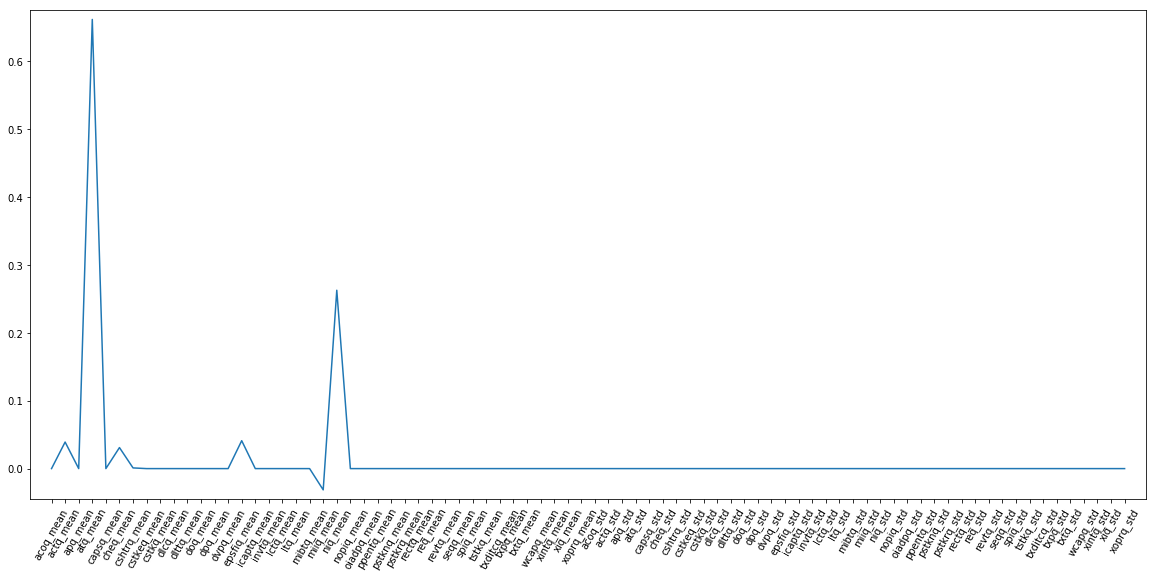

In [57]:
# Plot the coefficients
figsize = (20,9)
plt.figure(figsize=figsize)
plt.plot(range(len(reg_panel.iloc[:, 4:].columns)), lasso_coef)
plt.xticks(range(len(reg_panel.iloc[:, 4:].columns)), reg_panel.iloc[:, 4:].columns.values, rotation=60)
plt.margins(0.02)
plt.show()

In [58]:
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

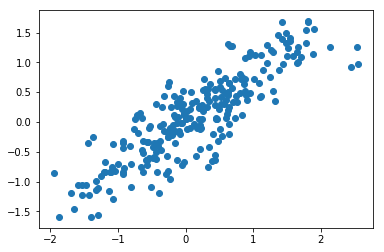

In [59]:
plt.scatter(y_test,y_test_pred)

In [60]:
from sklearn.metrics import mean_squared_error, r2_score
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_test_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_test_pred))

Mean squared error: 0.21
Variance score: 0.74


In [61]:
# bad example
pd.concat([all_vars['niq'].loc[:, 61701], all_vars['atq'].shift(1).loc[:, 61701]], axis=1).dropna()

,61701,61701
datadate,,
1996-09-30,4.375,533.081
1996-12-31,6.835,574.440
1997-03-31,2.676,586.192
1997-06-30,4.410,592.788
1997-09-30,8.284,634.582
1997-12-31,12.066,1539.740
1998-03-31,-4.287,1569.511
1998-12-31,1.176,0.043
1999-03-31,1.528,111.406


In [62]:
def remove_extreme_values(df, limit=4):
    limit = 8

    df_med = df.quantile(0.5, 1)
    df_med_dev = np.abs(df.sub(df_med, 0)).quantile(0.5, 1)

    up = df.sub(df_med.add(df_med_dev * limit, 0), 0)
    dn = df.sub(df_med.sub(df_med_dev * limit, 0), 0)
    
    return df[(up<0) & (dn>0)]

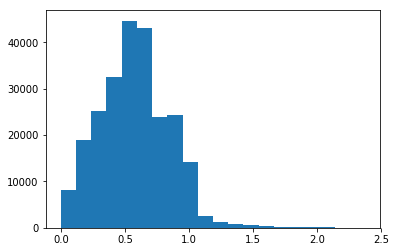

In [63]:
_=plt.hist(remove_extreme_values(all_vars['ltq']/all_vars['atq'].shift(1)).stack().values, bins=20)

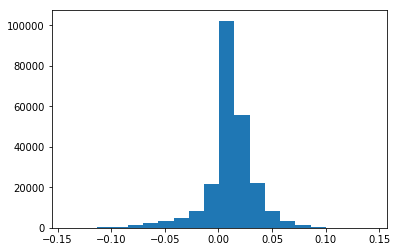

In [64]:
_=plt.hist(remove_extreme_values(all_vars['niq']/all_vars['atq'].shift(1)).stack().values,bins=20)

In [19]:
import pandas as pd
a = pd.Series([1,2,3,4,5,6,7])
print(a.shift(3))

0    NaN
1    NaN
2    NaN
3    1.0
4    2.0
5    3.0
6    4.0
dtype: float64
